# Importing the required libraries


In [1]:
# import statements
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchvision.transforms import ToTensor
import pandas as pd
from tqdm.notebook import tqdm
from yellowbrick.classifier import ClassificationReport
from texttable import Texttable
from pytorch_lightning import Trainer
import warnings  # ignore any warnings
warnings.filterwarnings("ignore")
from preprocessing import*

# Training Dataset Creation

Loading the dataset from the directory

In [2]:
directory_path = "./AI_Dataset/data/" # path directory
dataset = load_data(directory_path)  # load dataset from the given directory

Counting the number of images present in each of the classes

In [3]:
print(type(dataset))
print("The number of images for the")
# def data_class_distribution(dataset):  # gives the count of each classes of the dataset i.e. no of images per class
#     data_class_count = {}
#     for _, index in dataset:
#         label = classes[index]
#         if label not in data_class_count:
#             data_class_count[label] = 0
#         data_class_count[label] += 1
#     return data_class_count  # returns the count
    
# data_class_count = data_class_distribution(dataset)
# print("The number of images present in each of the three classes:", data_class_count) # print count of classes

<class 'torchvision.datasets.folder.ImageFolder'>
The number of images for the


Splitting the Data into the training data comprise 60% of the full data set. The validation and testing data each comprise 20% of the original data.

In [4]:
train_dataset, val_dataset, test_dataset = split_data(dataset)

# Loading Data with the help of DataLoader

In [5]:
train_loader = train_dataloarder(train_dataset)
val_loader = validation_dataloarder(val_dataset)
test_loader = test_dataloarder(test_dataset)

print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))
print("Length of the test_loader:", len(test_loader))

Length of the train_loader: 96
Length of the val_loader: 32
Length of the test_loader: 32


# Convolutional Neural Network Architecture and model training

CNN Model Architecture
- Consist of three major blocks in the CNN Model

In [6]:
class CNN(nn.Module):  # CNN Model class
 
    def __init__(self):
        super(CNN, self).__init__()    # blocks architecture
        self.conv_layer = nn.Sequential(   
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # block 1
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # block 2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # block 3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fully_connected_layer = nn.Sequential(  # full connected layer
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 32, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(128, 3)
        )

    def forward(self, x):   # forward pass on the CNN Model
    
        x = self.conv_layer(x) # convolutional layers

   
        x = x.view(x.size(0), -1)  # flattening the layers

    
        x = self.fully_connected_layer(x) # fully connected layer

        return x

CNN model, loss function and Optimizer initialization


In [7]:
net = CNN()  # calling Model 
criterion = nn.CrossEntropyLoss()  # loss criteria
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # using Stochastic Gradient Descent as a optimizer
# lrf = LearningRateFinder(net, criterion, optimizer)  # to find the best learning rate on the model
# lrf.fit(train_loader)
# lrf.plot() # plot the best learning rate 


#Training the CNN model

Conversion of output probabilities to predicted class labels

In [8]:
def images_to_probs(net, images):  # to predict the class labels 
    output = net(images)
    _, preds_tensor = torch.max(output, 1)  
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

Evaluation function 


In [9]:
def evaluate_accuracy(net, dataloader):  # method to evaluate the accuracy of the passed dataset
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images, labels.numpy()

            preds, probs = images_to_probs(net, images)

            total += len(labels)   # counting total no. of dataset
            correct += (preds == labels).sum()  # counting correct predictions done by the model
    return correct/total * 100

Train CNN Model for the given Parameters



In [10]:
def train_model(net,  criterion, opt, dataloader, epochs):  # train model based on the given parameter
    num_steps = 0  
    min_loss = 1e+10
    running_loss = []  # to store the loss of each epochs 
    epochs_loss = []
    accuracy = []  # to store the accuracy of each epochs
    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        
        net.train() # Setting the network to TRAIN mode
        for images, labels in dataloader:
            images, labels = images, labels
            num_steps += 1

            
            outs = net(images)   # Forward Propagation on the Model
            loss =  criterion(outs, labels)

            
            running_loss.append(loss.item()) # Storing loss values

           # Backward Propagation on the Model
            opt.zero_grad()   
            loss.backward()
            opt.step()

        
        epoch_loss = sum(running_loss) / len(running_loss) # calculating loss for each epoch
        epochs_loss.append(epoch_loss)
        acc = evaluate_accuracy(net, dataloader) # calculating the accuracy for each epoch
        accuracy.append(acc)
        print("Accuracy of the Model in epoch {} : {}".format(num_steps, acc)) 
        print("Loss of the current epoch: ",epoch_loss)
        
        if epoch_loss < min_loss:  # Finding the minimum loss
            min_loss = epoch_loss
            bestmodel = net.state_dict()
    return running_loss, epochs_loss, accuracy

    print('Training finished on the Train data-sets!!!')

In [11]:
num_epochs = 20   # define no. of epochs to run
running_loss,epochs_loss,accuracy = train_model(net, criterion, optimizer, train_loader, num_epochs)  # train dataset


Accuracy of the Model in epoch 96 : 80.29350104821803
Loss of the current epoch:  1.0318223480135202
Accuracy of the Model in epoch 192 : 89.51781970649894
Loss of the current epoch:  0.8089766254415736
Accuracy of the Model in epoch 288 : 95.49266247379455
Loss of the current epoch:  0.6253419122270619
Accuracy of the Model in epoch 384 : 98.9517819706499
Loss of the current epoch:  0.5015898937514672
Accuracy of the Model in epoch 480 : 98.0083857442348
Loss of the current epoch:  0.4215047047880944
Accuracy of the Model in epoch 576 : 99.58071278825996
Loss of the current epoch:  0.36031593085418634
Accuracy of the Model in epoch 672 : 100.0
Loss of the current epoch:  0.31285322124105214
Accuracy of the Model in epoch 768 : 100.0
Loss of the current epoch:  0.27480169201961263
Accuracy of the Model in epoch 864 : 100.0
Loss of the current epoch:  0.24521962624725416
Accuracy of the Model in epoch 960 : 100.0
Loss of the current epoch:  0.22153373292009443
Accuracy of the Model in e

Training Loss Plot

[1.0318223480135202, 0.8089766254415736, 0.6253419122270619, 0.5015898937514672, 0.4215047047880944, 0.36031593085418634, 0.31285322124105214, 0.27480169201961263, 0.24521962624725416, 0.22153373292009443, 0.20194248121410827, 0.18529935660012598, 0.17117977493969122, 0.15906116601589324, 0.1485296431400305, 0.13931299090177163, 0.1324860487665515, 0.12545800937879095, 0.11892934749121116, 0.1130500712441299]


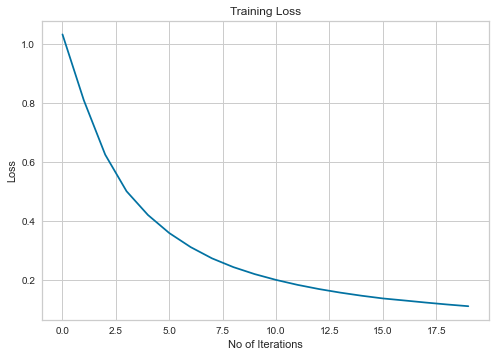

In [12]:
print(epochs_loss)
plt.plot(epochs_loss, label='Training loss') # print loss of each epoch
plt.title("Training Loss")
plt.xlabel("No of Iterations")
plt.ylabel("Loss");

Training Accuracy Plot

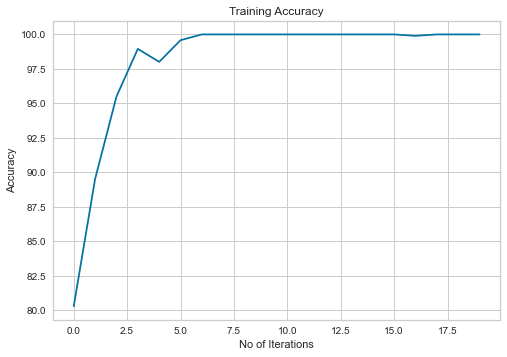

In [13]:
plt.plot(accuracy, label="Training Accuracy") # print accuracy of each epoch
plt.title("Training Accuracy")
plt.xlabel("No of Iterations")
plt.ylabel("Accuracy");

# Validating Network

Prediction of the Images


In [14]:
def prediction(predlab, testlab):  # method to show comparsion between Actual vs Predicted
    print("Prediction vs Actual class Label")
    predicted_list = []
    actual_list = []
    for i in predlab:
        if i == 0:  
            predicted_list.append("without_mask")
        elif i ==1: 
            predicted_list.append("with_mask")
        else :
            predicted_list.append("not_a_person")
 
    for i in testlab:
        if i == 0:  
            actual_list.append("without_mask")
        elif i ==1:
            actual_list.append("with_mask")
        else:
            actual_list.append("not_a_person")
        
    t = Texttable()
    main_row = [['Predicted', 'Actual']]

    for i in range(0, len(predicted_list)):
        tmp = [predicted_list[i],actual_list[i]]
        main_row.append(tmp)
    t.add_rows(main_row)
    print(t.draw()) # printing the talbe

In [15]:
acc = evaluate_accuracy(net, val_loader)   # evaluate the accuracy on the validation set
print("Accuracy of the Model on Test set: ",acc)
testimg, testlab = next(iter(val_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)  

prediction(predlab, testlab) # predictions of the validation set

Accuracy of the Model on Test set:  96.86520376175548
Prediction vs Actual class Label
+--------------+--------------+
|  Predicted   |    Actual    |
+==============+==============+
| with_mask    | with_mask    |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| not_a_person | not_a_person |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+
| not_a_person | not_a_person |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+


# Testing Network



In [16]:
acc = evaluate_accuracy(net, test_loader)  # evaluate the accuracy on the test set
print("Accuracy of the Model on Test set: ",acc)
testimg, testlab = next(iter(test_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)
prediction(predlab[0:10], testlab[0:10]) # predictions of the first 10 test set


Accuracy of the Model on Test set:  96.86520376175548
Prediction vs Actual class Label
+--------------+--------------+
|  Predicted   |    Actual    |
+==============+==============+
| not_a_person | not_a_person |
+--------------+--------------+
| not_a_person | not_a_person |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+


# Convolutional Neural Network Model Evaluation
1. Confustion Matrix
2. Precision
3. Recall
4. Accuracy
5. F1-Score

# Confusion Matrix

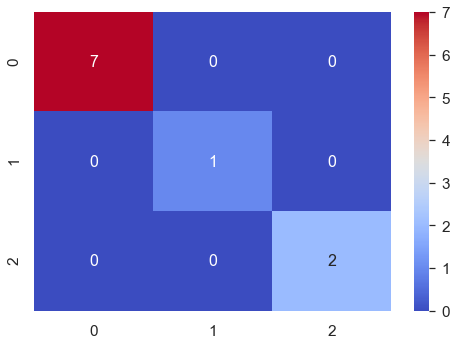

[[7 0 0]
 [0 1 0]
 [0 0 2]]


In [17]:
pred = predlab.numpy()   # plot the confusion matrix 
test = testlab.numpy()
matrix = confusion_matrix(test,pred)
sns.set(font_scale=1.4) # for label size
sns.heatmap(matrix, annot=True, annot_kws={"size": 16},cmap="coolwarm")  # use of heatmap
plt.show()  # plot confusion matrix
print(matrix)


# Classification Report

In [18]:
report = classification_report(test, pred, target_names=['with_mask','without_mask','not_a_person'])
print(report)  

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00         7
without_mask       1.00      1.00      1.00         1
not_a_person       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

